In [1]:
%cd /nfsd/sysbiobig/bazzaccoen/tangramlit_dev

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev


In [2]:
import scanpy as sc
import squidpy as sq
import numpy as np 
import pandas as pd
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text 

# Data preparation

In [3]:
# Set data path
data_path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/data/Dataset8/"

## SC data


#### Data reading

In [4]:
# read counts
from scipy import io

X = io.mmread(data_path + "sc_data_files/matrix.mtx.gz").T.tocsr()
X.shape

(176584, 31053)

In [6]:
from scipy import sparse

min_val = X.min()
max_val = X.max()
mean_val = X.mean()
median_val = np.median(X.data)  # median only over nonzero entries

In [7]:
for value in [min_val, max_val, mean_val, median_val]:
    print(value)

0
11028
0.9832901938425115
2.0


Counts are probably raw.

In [5]:
# read IDs
genes = pd.read_csv(data_path + "sc_data_files/features.tsv.gz", sep="\t", header=None)
genes.columns = ["gene_id", "gene_name", "feature_type"]

barcodes = pd.read_csv(data_path + "sc_data_files/barcode.tsv", sep=",", header=0, index_col=0)  # comma separated!
barcodes.columns = ["barcode"]


In [6]:
# create minimal anndata
adata_sc_full = sc.AnnData(X)
adata_sc_full.var["gene_id"] = genes["gene_id"].values
adata_sc_full.var_names = genes["gene_name"].values
adata_sc_full.obs_names = barcodes["barcode"]
adata_sc_full

AnnData object with n_obs × n_vars = 176584 × 31053
    var: 'gene_id'

In [7]:
# Cell metadata
meta = pd.read_csv(data_path + "sc_data_files/sample_metadata.csv", index_col=0)

# QC metrics
qc = pd.read_csv(data_path + "sc_data_files/QC.csv", index_col=0)

# Cluster membership
membership = pd.read_csv(data_path + "sc_data_files/cluster.membership.csv", index_col=0)

# Cluster map
annot = pd.read_csv(data_path + "sc_data_files/cluster.annotation.csv", index_col=0)


#### Cell metadata

In [11]:
meta.head()  # useful columns: doublet.score

,aggr_num,umi.counts,gene.counts,library_id,tube_barcode,Seq_batch,Region,Lib_type,Gender,Donor,...,Live_percent,Total_Cells,Live_Cells,method,exp_component_name,mapped_reads,unmapped_reads,nonconf_mapped_reads,total.reads,doublet.score
AAACCCAAGCTTCATG-1L8TX_181211_01_G12,1,55812,7122,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,426003,...,75%,7882,5898,10xv3,AAACCCAAGCTTCATG-1L8TX_181211_01_G12,141238,2460,11355,155053.0,0.154639
AAACCCAAGGCGCTTC-1L8TX_181211_01_G12,1,1670,668,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,426003,...,75%,7882,5898,10xv3,AAACCCAAGGCGCTTC-1L8TX_181211_01_G12,4160,64,1049,5273.0,0.030928
AAACCCAAGGCTTAAA-1L8TX_181211_01_G12,1,1873,406,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,426003,...,75%,7882,5898,10xv3,AAACCCAAGGCTTAAA-1L8TX_181211_01_G12,6404,47,2539,8990.0,0.000000
AAACCCAAGTGAGGTC-1L8TX_181211_01_G12,1,36622,6125,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,426003,...,75%,7882,5898,10xv3,AAACCCAAGTGAGGTC-1L8TX_181211_01_G12,90968,1351,7997,100316.0,0.163265
AAACCCACACCAGCCA-1L8TX_181211_01_G12,1,90475,8322,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,426003,...,75%,7882,5898,10xv3,AAACCCACACCAGCCA-1L8TX_181211_01_G12,240181,4107,20590,264878.0,0.164948


In [8]:
# add to adata
adata_sc_full.obs = meta.loc[adata_sc_full.obs_names].copy()
adata_sc_full

AnnData object with n_obs × n_vars = 176584 × 31053
    obs: 'aggr_num', 'umi.counts', 'gene.counts', 'library_id', 'tube_barcode', 'Seq_batch', 'Region', 'Lib_type', 'Gender', 'Donor', 'Amp_Name', 'Amp_Date', 'Amp_PCR_cyles', 'Lib_Name', 'Lib_Date', 'Replicate_Lib', 'Lib_PCR_cycles', 'Lib_PassFail', 'Cell_Capture', 'Lib_Cells', 'Mean_Reads_perCell', 'Median_Genes_perCell', 'Median_UMI_perCell', 'Saturation', 'Live_percent', 'Total_Cells', 'Live_Cells', 'method', 'exp_component_name', 'mapped_reads', 'unmapped_reads', 'nonconf_mapped_reads', 'total.reads', 'doublet.score'
    var: 'gene_id'

#### Quality control - Empty droplets filtering

In [15]:
qc.head()  # id of cells that passed QC

,x
1,AAACCCAAGCTTCATG-1L8TX_181211_01_G12
2,AAACCCAAGTGAGGTC-1L8TX_181211_01_G12
3,AAACCCACACCAGCCA-1L8TX_181211_01_G12
4,AAACCCAGTGAACGGT-1L8TX_181211_01_G12
5,AAACCCAGTGGCATCC-1L8TX_181211_01_G12


In [9]:
# subset andata to only QC passed cells
adata_sc = adata_sc_full[adata_sc_full.obs_names.isin(qc.x), :].copy()
adata_sc

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 71183 × 31053
    obs: 'aggr_num', 'umi.counts', 'gene.counts', 'library_id', 'tube_barcode', 'Seq_batch', 'Region', 'Lib_type', 'Gender', 'Donor', 'Amp_Name', 'Amp_Date', 'Amp_PCR_cyles', 'Lib_Name', 'Lib_Date', 'Replicate_Lib', 'Lib_PCR_cycles', 'Lib_PassFail', 'Cell_Capture', 'Lib_Cells', 'Mean_Reads_perCell', 'Median_Genes_perCell', 'Median_UMI_perCell', 'Saturation', 'Live_percent', 'Total_Cells', 'Live_Cells', 'method', 'exp_component_name', 'mapped_reads', 'unmapped_reads', 'nonconf_mapped_reads', 'total.reads', 'doublet.score'
    var: 'gene_id'

To asses the effect of QC filtering we check the total counts per cell distributions:

In [11]:
import scipy
adata_sc_full.obs['total_counts'] = adata_sc_full.X.sum(axis=1).A1 if scipy.sparse.issparse(adata_sc_full.X) else adata_sc_full.X.sum(1)
adata_sc.obs['total_counts'] = adata_sc.X.sum(axis=1).A1 if scipy.sparse.issparse(adata_sc.X) else adata_sc.X.sum(1)

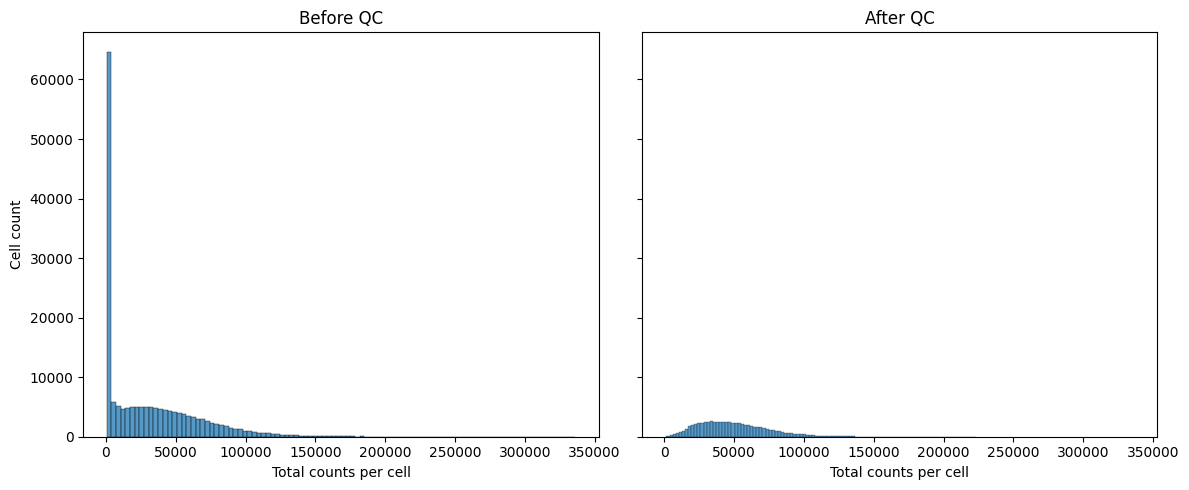

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

sns.histplot(adata_sc_full.obs['total_counts'], bins=100, ax=axes[0])
axes[0].set_title('Before QC')
axes[0].set_xlabel('Total counts per cell')
axes[0].set_ylabel('Cell count')

sns.histplot(adata_sc.obs['total_counts'], bins=100, ax=axes[1])
axes[1].set_title('After QC')
axes[1].set_xlabel('Total counts per cell')

plt.tight_layout()
plt.show()


Clearly it removes empty cells, so we remove the lower count cells from the full data to better see the result on higher counts:

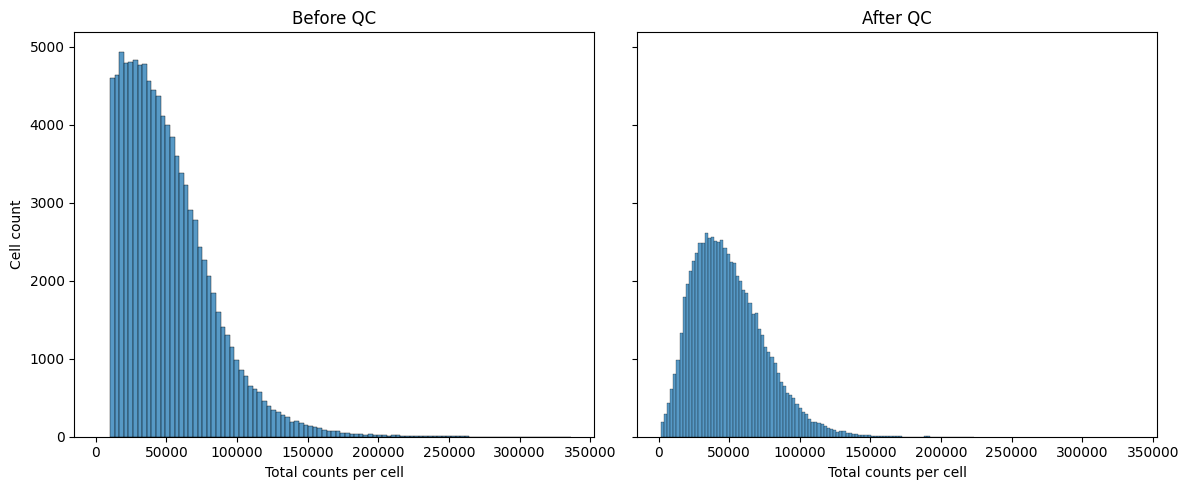

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

sns.histplot(adata_sc_full[adata_sc_full.obs['total_counts'] > 1e4].obs['total_counts'], bins=100, ax=axes[0])
axes[0].set_title('Before QC')
axes[0].set_xlabel('Total counts per cell')
axes[0].set_ylabel('Cell count')

sns.histplot(adata_sc.obs['total_counts'], bins=100, ax=axes[1])
axes[1].set_title('After QC')
axes[1].set_xlabel('Total counts per cell')

plt.tight_layout()
plt.show()


This shows that low count cells are alredy filtered out effectively with QC.

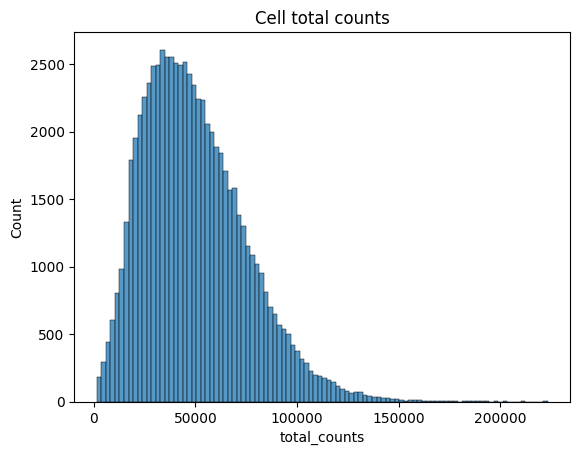

In [15]:
sns.histplot(adata_sc.obs['total_counts'], bins=100)
plt.title('Cell total counts')
plt.show()

#### Doublets removal

First we inspect the double score distribution:

Text(0.5, 1.0, 'Distribution of doublet scores')

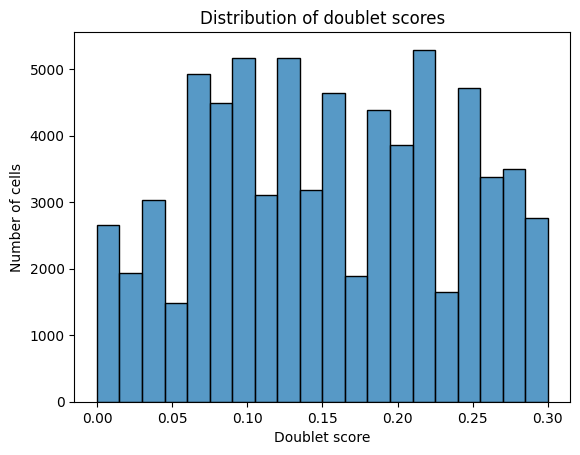

In [16]:
sns.histplot(adata_sc.obs["doublet.score"], bins=20)
plt.xlabel("Doublet score")
plt.ylabel("Number of cells")
plt.title("Distribution of doublet scores")

In [17]:
adata_sc.obs['doublet.score'].max()

np.float64(0.3)

This distribution of doublet score suggests than doublets have already been removed, even though no flag is present.

#### Annotation

In [18]:
membership

,x
AAACCCAAGCTTCATG-1L8TX_181211_01_G12,42
AAACCCAAGTGAGGTC-1L8TX_181211_01_G12,41
AAACCCACACCAGCCA-1L8TX_181211_01_G12,42
AAACCCAGTGAACGGT-1L8TX_181211_01_G12,41
AAACCCAGTGGCATCC-1L8TX_181211_01_G12,20
...,...
TTTGTTGTCAGCATTG-12L8TX_190430_01_G08,40
TTTGTTGTCATTGCGA-12L8TX_190430_01_G08,41
TTTGTTGTCCCAACTC-12L8TX_190430_01_G08,43
TTTGTTGTCTATGCCC-12L8TX_190430_01_G08,42


In [19]:
annot

,cluster_label,subclass_label,class_label,cluster_color,size
cluster_id,,,,,
1,Lamp5 Pax6,Lamp5,GABAergic,#DDACC9,81
2,Lamp5 Egln3_2_1,Lamp5,GABAergic,#DD8091,179
3,Lamp5 Pdlim5_1,Lamp5,GABAergic,#FF829E,247
4,Lamp5 Pdlim5_2,Lamp5,GABAergic,#FF7290,537
5,Lamp5 Slc35d3_1,Lamp5,GABAergic,#FFA388,1275
...,...,...,...,...,...
143,L6b Shisa6_low_1,Low Quality,Low Quality,#5A7A65,84
144,L6b Shisa6_low_2,Low Quality,Low Quality,#1F7C70,95
145,Oligo Opalin_neuon,doublet,Low Quality,#41775C,16


In [20]:
# merge membership with annotation
merged = membership.merge(annot, left_on="x", right_index=True, how="left")

# add into adata.obs
adata_sc.obs = adata_sc.obs.join(merged, how="left")
adata_sc.obs.head()


,aggr_num,umi.counts,gene.counts,library_id,tube_barcode,Seq_batch,Region,Lib_type,Gender,Donor,...,nonconf_mapped_reads,total.reads,doublet.score,total_counts,x,cluster_label,subclass_label,class_label,cluster_color,size
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGCTTCATG-1L8TX_181211_01_G12,1,55812,7122,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,426003,...,11355,155053.0,0.154639,55812,42,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334
AAACCCAAGTGAGGTC-1L8TX_181211_01_G12,1,36622,6125,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,426003,...,7997,100316.0,0.163265,36622,41,L5 IT Tcap_1,L5 IT,Glutamatergic,#5DDB65,7462
AAACCCACACCAGCCA-1L8TX_181211_01_G12,1,90475,8322,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,426003,...,20590,264878.0,0.164948,90475,42,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334
AAACCCAGTGAACGGT-1L8TX_181211_01_G12,1,98226,8681,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,426003,...,19646,261066.0,0.163265,98226,41,L5 IT Tcap_1,L5 IT,Glutamatergic,#5DDB65,7462
AAACCCAGTGGCATCC-1L8TX_181211_01_G12,1,74567,8081,L8TX_181211_01_G12,SM-HH8FP-1,RTX-841,MOp,Cells_FACS-tdT,Male,426003,...,19128,218159.0,0.144330,74567,20,Vip Gpc3,Vip,GABAergic,#B09FFF,314


Since the full Tangram model requires sc annotations, we remove all cells with a missing value (none in the QC filtered dataset):

In [21]:
adata_sc = adata_sc[adata_sc.obs['x'].notna()]
adata_sc

View of AnnData object with n_obs × n_vars = 71183 × 31053
    obs: 'aggr_num', 'umi.counts', 'gene.counts', 'library_id', 'tube_barcode', 'Seq_batch', 'Region', 'Lib_type', 'Gender', 'Donor', 'Amp_Name', 'Amp_Date', 'Amp_PCR_cyles', 'Lib_Name', 'Lib_Date', 'Replicate_Lib', 'Lib_PCR_cycles', 'Lib_PassFail', 'Cell_Capture', 'Lib_Cells', 'Mean_Reads_perCell', 'Median_Genes_perCell', 'Median_UMI_perCell', 'Saturation', 'Live_percent', 'Total_Cells', 'Live_Cells', 'method', 'exp_component_name', 'mapped_reads', 'unmapped_reads', 'nonconf_mapped_reads', 'total.reads', 'doublet.score', 'total_counts', 'x', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size'
    var: 'gene_id'

#### Filter genes

/tmp/ipykernel_3811675/3737281526.py:3: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_sc.var['n_cells_expressed'] = np.array((adata_sc.X > 0).sum(axis=0)).ravel()
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


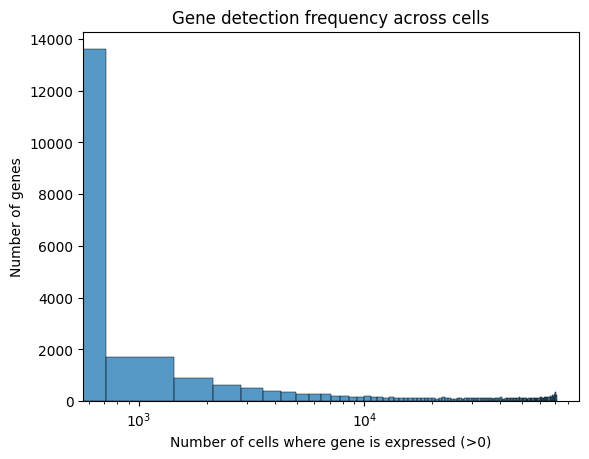

In [22]:
# compute counts if not already done
if 'n_cells_expressed' not in adata_sc.var.columns:
    adata_sc.var['n_cells_expressed'] = np.array((adata_sc.X > 0).sum(axis=0)).ravel()

# histogram (log scale on x is clearer)
sns.histplot(adata_sc.var['n_cells_expressed'], bins=100)
plt.xscale('log')
plt.xlabel('Number of cells where gene is expressed (>0)')
plt.ylabel('Number of genes')
plt.title('Gene detection frequency across cells')
plt.show()

In [23]:
sc.pp.filter_genes(adata_sc, min_cells=1)
adata_sc

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 71183 × 27439
    obs: 'aggr_num', 'umi.counts', 'gene.counts', 'library_id', 'tube_barcode', 'Seq_batch', 'Region', 'Lib_type', 'Gender', 'Donor', 'Amp_Name', 'Amp_Date', 'Amp_PCR_cyles', 'Lib_Name', 'Lib_Date', 'Replicate_Lib', 'Lib_PCR_cycles', 'Lib_PassFail', 'Cell_Capture', 'Lib_Cells', 'Mean_Reads_perCell', 'Median_Genes_perCell', 'Median_UMI_perCell', 'Saturation', 'Live_percent', 'Total_Cells', 'Live_Cells', 'method', 'exp_component_name', 'mapped_reads', 'unmapped_reads', 'nonconf_mapped_reads', 'total.reads', 'doublet.score', 'total_counts', 'x', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size'
    var: 'gene_id', 'n_cells_expressed', 'n_cells'

#### Normalization
CP10K and log1p:

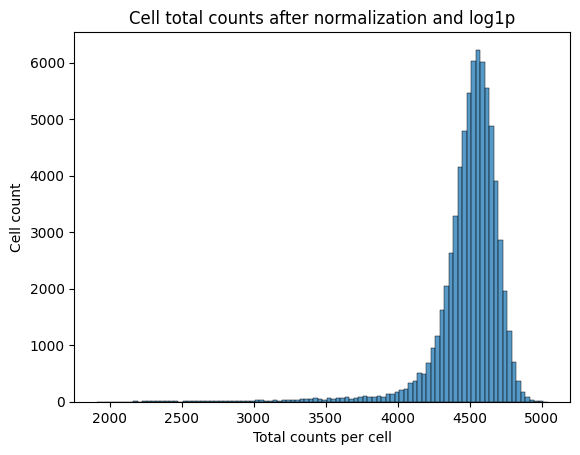

In [24]:
sc.pp.normalize_total(adata_sc, target_sum=1e4)
sc.pp.log1p(adata_sc)
# update counts
adata_sc.obs['total_counts'] = np.array(adata_sc.X.sum(axis=1)).ravel()

sns.histplot(adata_sc.obs['total_counts'], bins=100)
plt.title('Cell total counts after normalization and log1p')
plt.xlabel('Total counts per cell')
plt.ylabel('Cell count')
plt.show()

#### Sparsity
Annotate total sparsity:

In [25]:
## add sparsity in uns
# handle sparse or dense automatically
X = adata_sc.X
if not isinstance(X, np.ndarray):
    X = X.copy()  # ensures .count_nonzero() works

# compute sparsity = fraction of zero entries
n_total = np.prod(adata_sc.shape)
n_nonzero = X.count_nonzero() if hasattr(X, "count_nonzero") else np.count_nonzero(X)
sparsity = 1 - (n_nonzero / n_total)

adata_sc.uns["sparsity"] = float(sparsity)
print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.7394


#### HVGs

In [26]:
sc.pp.highly_variable_genes(
    adata_sc,
    n_top_genes=2000,
    flavor='seurat_v3'
)
adata_sc

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


AnnData object with n_obs × n_vars = 71183 × 27439
    obs: 'aggr_num', 'umi.counts', 'gene.counts', 'library_id', 'tube_barcode', 'Seq_batch', 'Region', 'Lib_type', 'Gender', 'Donor', 'Amp_Name', 'Amp_Date', 'Amp_PCR_cyles', 'Lib_Name', 'Lib_Date', 'Replicate_Lib', 'Lib_PCR_cycles', 'Lib_PassFail', 'Cell_Capture', 'Lib_Cells', 'Mean_Reads_perCell', 'Median_Genes_perCell', 'Median_UMI_perCell', 'Saturation', 'Live_percent', 'Total_Cells', 'Live_Cells', 'method', 'exp_component_name', 'mapped_reads', 'unmapped_reads', 'nonconf_mapped_reads', 'total.reads', 'doublet.score', 'total_counts', 'x', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size'
    var: 'gene_id', 'n_cells_expressed', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'sparsity', 'hvg'

#### Save

In [28]:
sc.write(filename=data_path + "scRNA_data.h5ad", adata=adata_sc, ext='h5ad')

## MERFISH data
Full spatial data (counts and metadata) are availabel in the unzipped `merfish-updated.h5ad.gz`. Only steps necessary to align to the benchmarking set is to subset on ‘mouse1_slice162’ and create the `obsm['spatial']` field.

In [7]:
adata_st = sc.read_h5ad(data_path + "merfish-updated.h5ad")
adata_st


/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 280327 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'cell_id'
    var: 'n_iso'
    layers: 'X', 'log1p', 'norm'

In [5]:
adata_st.obs['slice_id'].value_counts()

slice_id
mouse1_slice153    7656
mouse1_slice162    6963
mouse1_slice102    6731
mouse1_slice212    6535
mouse1_slice170    6459
                   ... 
mouse2_slice31     2037
mouse1_slice21     2033
mouse2_slice1      1706
mouse2_slice10     1160
mouse2_slice20      670
Name: count, Length: 64, dtype: int64

In [ ]:
# subset on a single sample/slice
adata_st = adata_st[adata_st.obs['slice_id'] == 'mouse1_slice162']
# add spatial coordinates
adata_st.obsm['spatial'] = adata_st.obs[['center_x', 'center_y']].to_numpy()
adata_st

/tmp/ipykernel_2835956/127073224.py:2: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata_st.obsm['spatial'] = adata_st.obs[['center_x', 'center_y']].to_numpy()


AnnData object with n_obs × n_vars = 6963 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'cell_id'
    var: 'n_iso'
    obsm: 'spatial'
    layers: 'X', 'log1p', 'norm'

Final data shape matches the benchmarking paper exactly.

#### Spatial scatter plot

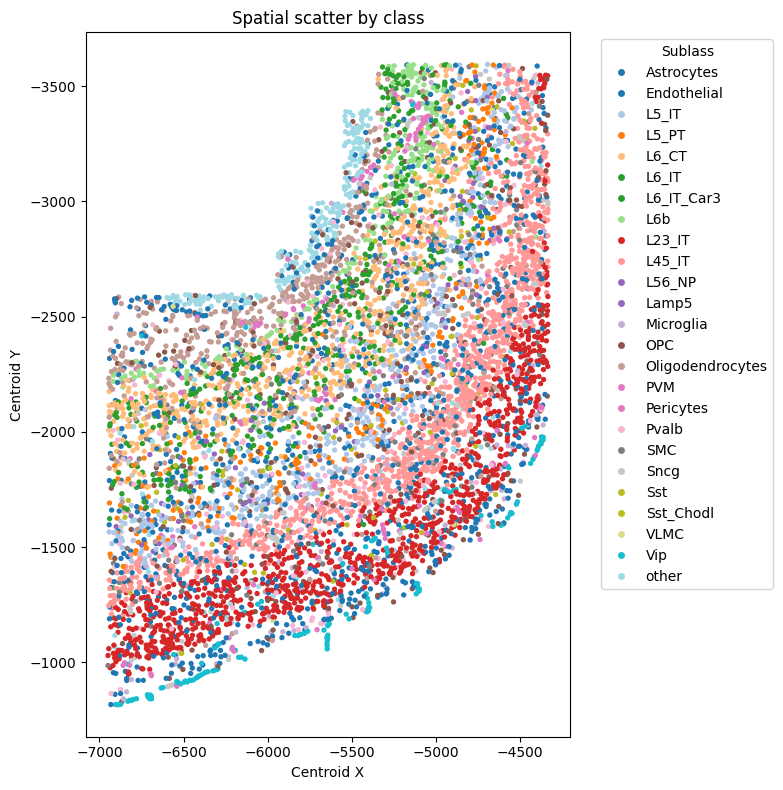

In [32]:
x = adata_st.obs['center_x']
y = adata_st.obs['center_y']
labels = adata_st.obs['subclass'].astype('category')
codes = labels.cat.codes
categories = labels.cat.categories

plt.figure(figsize=(8,8))
sc = plt.scatter(x, y, c=codes, cmap='tab20', s=8)
plt.xlabel('Centroid X')
plt.ylabel('Centroid Y')
plt.title('Spatial scatter by class')
plt.gca().invert_yaxis()

# legend mapping colors to categories
handles = [plt.Line2D([], [], marker='o', color='w', label=cat,
                      markerfacecolor=plt.cm.tab20(i / len(categories)), markersize=6)
           for i, cat in enumerate(categories)]
plt.legend(handles=handles, title='Sublass', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



#### Counts per cell
We show a histogram of the number of detected transcripts per cell in the spatial data, highlightnig the detection efficieny:

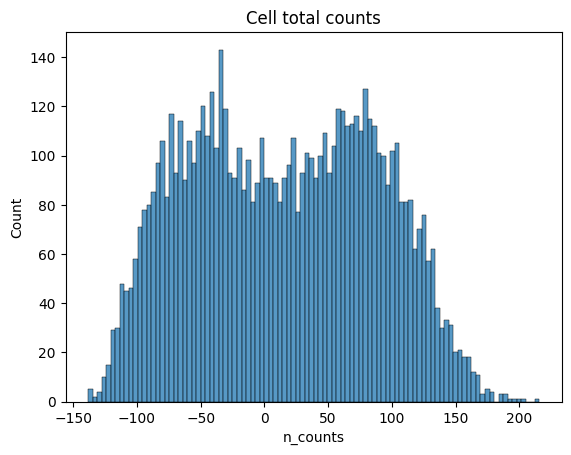

In [34]:
# compute n counts per spot
adata_st.obs['n_counts'] = np.array(adata_st.X.sum(axis=1)).ravel()
sns.histplot(adata_st.obs['n_counts'], bins=100)
plt.title('Cell total counts')
plt.show()

Looking at this plot we can see that counts have likely been z-scored as they are pretty much 0-centered. We inspect the other count matrices in the data:

In [52]:
adata_st.layers

Layers with keys: X, log1p, norm

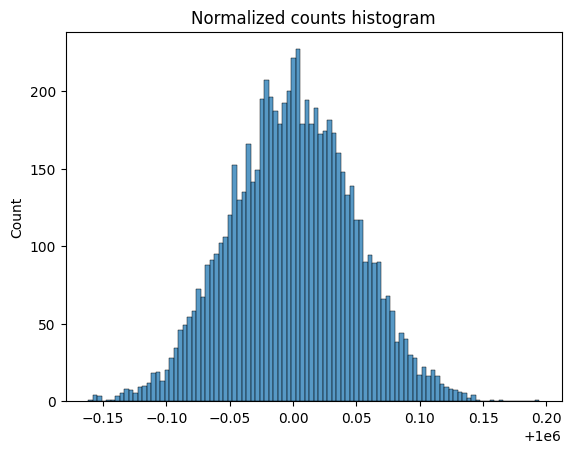

In [53]:
# normalized counts are in a np array
counts_norm = adata_st.layers['norm'].sum(axis=1)
sns.histplot(counts_norm, bins=100)
plt.title('Normalized counts histogram')
plt.show()

In [78]:
counts_norm.shape

(6963,)

This matrix has very large values...

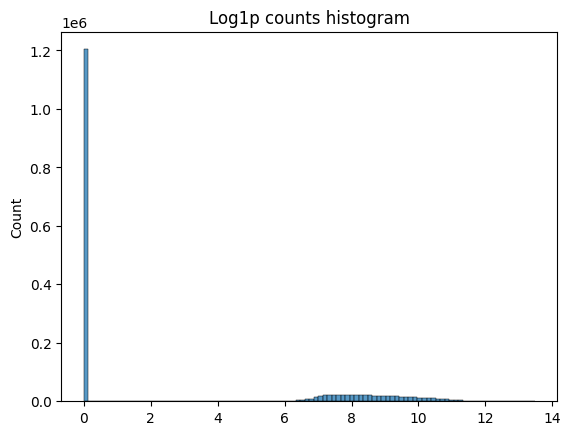

In [57]:
# logp counts are a sparse matrix
sns.histplot(adata_st.layers['log1p'].toarray().ravel(), bins=100)
plt.title('Log1p counts histogram')
plt.show()

In [80]:
adata_st.layers['log1p'].nnz

564763

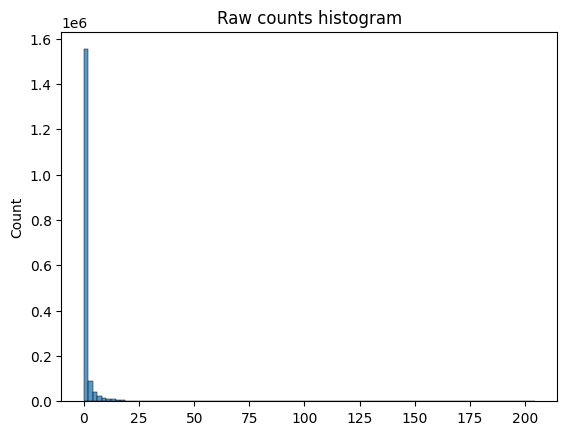

In [59]:
# same for raw
sns.histplot(adata_st.layers['X'].toarray().ravel(), bins=100)
plt.title('Raw counts histogram')
plt.show()

In [81]:
adata_st.layers['X'].nnz

564763

We learn that while layer `Norm` has been subset to our sample/slice, the other two layers still refer to the full dataset (looking at the huge number of non-zero entries) with empty cells included (looking at the 0-count peak).

<Axes: ylabel='Count'>

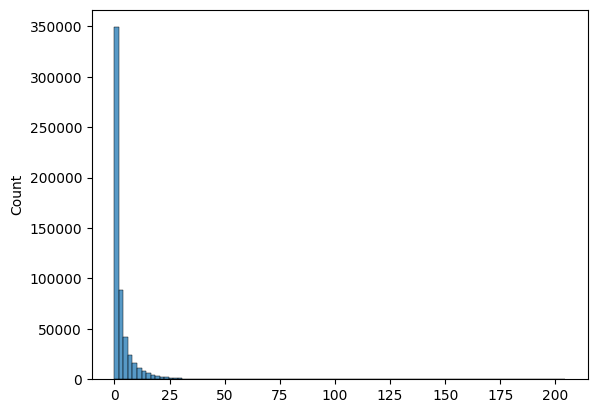

In [74]:
X = adata_st.layers['X']

if scipy.sparse.issparse(X):
    data = X.data  # nonzero entries only
else:
    data = X[X > 1e6].ravel()

sns.histplot(data, bins=100)

In [75]:
data.shape

(564763,)

#### Count shifting
The main count matrix seems to be the most appropriate choice fo all. Since the plausible mean and variance of the z-scoring are not available we opt for a min-value shift. This is to avoid negative expression values that are problematic for both Tangram and SA statistics:

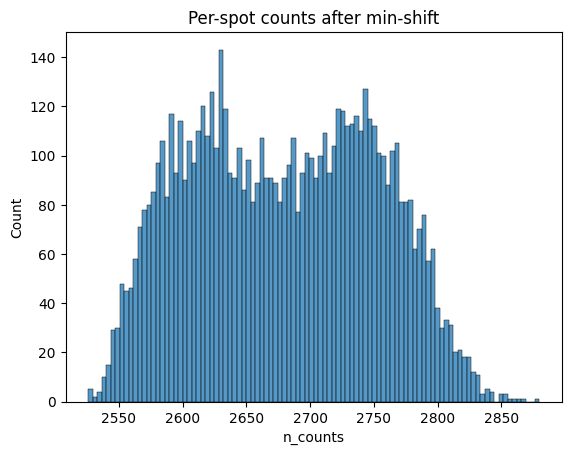

In [83]:
if scipy.sparse.issparse(adata_st.X):
    adata_st.X = adata_st.X + abs(adata_st.X.min())
else:
    adata_st.X -= adata_st.X.min()
adata_st.obs['n_counts'] = np.array(adata_st.X.sum(axis=1)).ravel()
sns.histplot(adata_st.obs['n_counts'], bins=100)
plt.title('Per-spot counts after min-shift')
plt.show()

In [88]:
print("Number of 0s in the data: ", (adata_st.X == 0).sum())

Number of 0s in the data:  1


#### Sparsity
Annotate total sparsity:

In [90]:
## add sparsity in uns
# handle sparse or dense automatically
X = adata_st.X
if not isinstance(X, np.ndarray):
    X = X.copy()  # ensures .count_nonzero() works

# compute sparsity = fraction of zero entries
n_total = np.prod(adata_st.shape)
n_nonzero = X.count_nonzero() if hasattr(X, "count_nonzero") else np.count_nonzero(X)
sparsity = 1 - (n_nonzero / n_total)

adata_st.uns["sparsity"] = float(sparsity)
print(f"Sparsity: {sparsity:.4f}")

Sparsity: 0.0000


The null sparsity matches the benchmarking paper reported values (data was already preprocessed).

#### Spatial graph

In [91]:
sq.gr.spatial_neighbors(
    adata_st,
    coord_type='generic',   # 'visium' for Visium, 'generic' for single-cell resolution
    n_neighs=6,   
    set_diag=False,           # or adjust based on local cell density
    key_added="spatial"
)
adata_st

AnnData object with n_obs × n_vars = 6963 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'cell_id', 'n_counts'
    var: 'n_iso'
    uns: 'sparsity', 'spatial_neighbors'
    obsm: 'spatial'
    layers: 'X', 'log1p', 'norm'
    obsp: 'spatial_connectivities', 'spatial_distances'

#### SA statistics

In [92]:
# Moran’s I
sq.gr.spatial_autocorr(
    adata_st,
    connectivity_key="spatial_connectivities",
    mode="moran",
    transformation=True,
    show_progress_bar=True,
)

# Geary’s C
sq.gr.spatial_autocorr(
    adata_st,
    connectivity_key="spatial_connectivities",
    mode="geary",
    transformation=True,
    show_progress_bar=True,
)
adata_st

AnnData object with n_obs × n_vars = 6963 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'cell_id', 'n_counts'
    var: 'n_iso'
    uns: 'sparsity', 'spatial_neighbors', 'moranI', 'gearyC'
    obsm: 'spatial'
    layers: 'X', 'log1p', 'norm'
    obsp: 'spatial_connectivities', 'spatial_distances'

#### Save

In [93]:
sc.write(filename=data_path + 'MERFISH_data.h5ad', adata=adata_st, ext='h5ad')

# Data Loading

In [95]:
adata_sc = sc.read_h5ad(data_path + "scRNA_data.h5ad")
adata_sc

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 71183 × 27439
    obs: 'aggr_num', 'umi.counts', 'gene.counts', 'library_id', 'tube_barcode', 'Seq_batch', 'Region', 'Lib_type', 'Gender', 'Donor', 'Amp_Name', 'Amp_Date', 'Amp_PCR_cyles', 'Lib_Name', 'Lib_Date', 'Replicate_Lib', 'Lib_PCR_cycles', 'Lib_PassFail', 'Cell_Capture', 'Lib_Cells', 'Mean_Reads_perCell', 'Median_Genes_perCell', 'Median_UMI_perCell', 'Saturation', 'Live_percent', 'Total_Cells', 'Live_Cells', 'method', 'exp_component_name', 'mapped_reads', 'unmapped_reads', 'nonconf_mapped_reads', 'total.reads', 'doublet.score', 'total_counts', 'x', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size'
    var: 'gene_id', 'n_cells_expressed', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'sparsity'

In [94]:
adata_st = sc.read(data_path + "MERFISH_data.h5ad") 
adata_st

AnnData object with n_obs × n_vars = 6963 × 254
    obs: 'fovID', 'fov_x', 'fov_y', 'volume', 'center_x', 'center_y', 'slice_id', 'sample_id', 'label', 'subclass', 'class_label', 'cell_id', 'n_counts'
    var: 'n_iso'
    uns: 'gearyC', 'moranI', 'sparsity', 'spatial_neighbors'
    obsm: 'spatial'
    layers: 'X', 'log1p', 'norm'
    obsp: 'spatial_connectivities', 'spatial_distances'

## Harmonization

In [96]:
# explore common cell types
print("scRNA cell types: \n", adata_sc.obs['subclass_label'].unique())
print("Spatial data cell types: \n", adata_st.obs['subclass'].unique())
common_cts = set(adata_sc.obs['subclass_label'].unique()) & set(adata_st.obs['subclass'].unique())
print(f"Common cell types: \n {common_cts} \n Length: {len(common_cts)}")

scRNA cell types: 
 ['L5 IT', 'Vip', 'L6 IT', 'L6 CT', 'L2/3 IT', ..., 'Sncg', 'L5 ET', 'L6 IT Car3', 'SMC', 'Pvalb']
Length: 20
Categories (20, object): ['Astro', 'Endo', 'L2/3 IT', 'L5 ET', ..., 'Sncg', 'Sst', 'VLMC', 'Vip']
Spatial data cell types: 
 ['Microglia', 'L6_IT', 'Astrocytes', 'Oligodendrocytes', 'L23_IT', ..., 'L6b', 'Pericytes', 'Lamp5', 'Sncg', 'Sst_Chodl']
Length: 25
Categories (25, object): ['Astrocytes', 'Endothelial', 'L5_IT', 'L5_PT', ..., 'Sst_Chodl', 'VLMC', 'Vip', 'other']
Common cell types: 
 {'Pvalb', 'Lamp5', 'OPC', 'Sst', 'SMC', 'L6b', 'Vip', 'VLMC', 'Sncg'} 
 Length: 9


In [97]:
adata_sc = adata_sc[adata_sc.obs['subclass_label'].isin(common_cts)]
adata_st = adata_st[adata_st.obs['subclass'].isin(common_cts)]

print(adata_sc.shape)
print(adata_st.shape)

(8674, 27439)
(869, 254)


Harmonization would drastically reduce the number of observations in both modalities. For spatial we are left with a few spots:

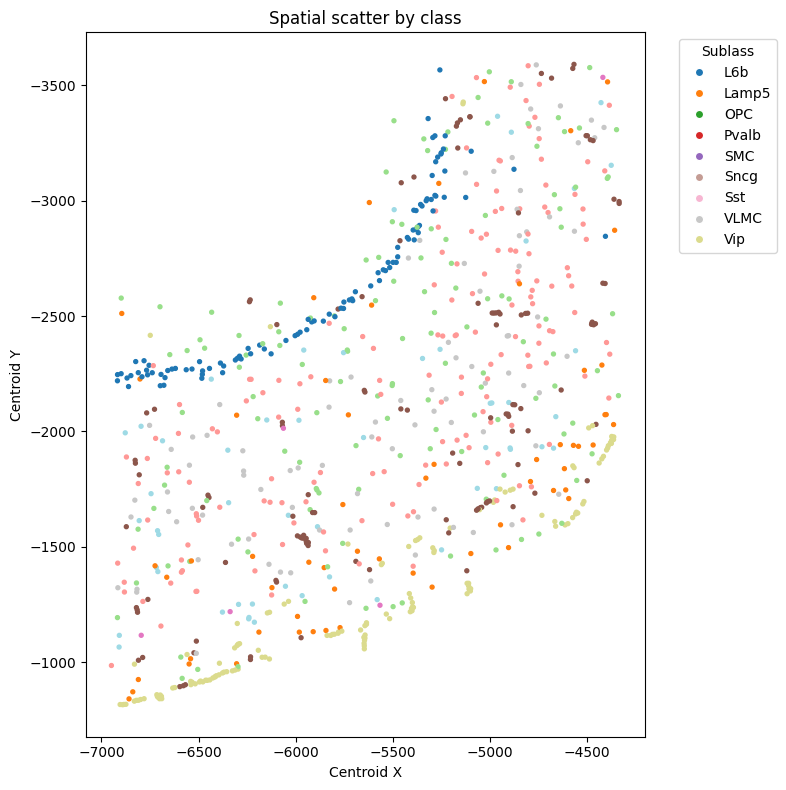

In [98]:
x = adata_st.obs['center_x']
y = adata_st.obs['center_y']
labels = adata_st.obs['subclass'].astype('category')
codes = labels.cat.codes
categories = labels.cat.categories

plt.figure(figsize=(8,8))
sc = plt.scatter(x, y, c=codes, cmap='tab20', s=8)
plt.xlabel('Centroid X')
plt.ylabel('Centroid Y')
plt.title('Spatial scatter by class')
plt.gca().invert_yaxis()

# legend mapping colors to categories
handles = [plt.Line2D([], [], marker='o', color='w', label=cat,
                      markerfacecolor=plt.cm.tab20(i / len(categories)), markersize=6)
           for i, cat in enumerate(categories)]
plt.legend(handles=handles, title='Sublass', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()